GPT2-Avg-Attention

In [1]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

1. Avg Attention

In [ ]:
cn_stopwords_path = 'F:/project/Attention/cn_stopwords.txt'  
with open(cn_stopwords_path, 'r', encoding='utf-8') as f:
    cn_stopwords = {line.strip() for line in f.readlines()}

#cn_stopwords = []

tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall')
model = GPT2LMHeadModel.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall', output_attentions=True).eval()

# corpus
with open("F:/project/Attention/corpus.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

fig, axs = plt.subplots(len(corpus), 12, figsize=(30, 20), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

all_attentions = []

for corpus_index, text in enumerate(corpus):
    #sentences = text.split('。')[:-1]
    #input_text = "[SEP] ".join(sentences) 

    #inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    sep_positions = [pos for pos, token in enumerate(tokens) if token == "。"]
    
    num_sentences = len(sep_positions) 
    
    for layer in range(12):
        '''
        all_heads_attention = []
        for i in [3,6,9,12]:
            head_attention = outputs.attentions[layer][0][i-1]
            all_heads_attention.append(head_attention)
        all_heads_attention = torch.stack(all_heads_attention).mean(dim=0)
        '''
        #all_heads_attention = outputs.attentions[layer][0].mean(dim=0)
        all_heads_attention = outputs.attentions[layer][0][3,:,:]
        sentence_attention = torch.zeros((num_sentences, num_sentences))

        for i in range(num_sentences):
            start_from = 0 if i == 0 else sep_positions[i-1] + 1
            end_from = sep_positions[i]

            for j in range(num_sentences):
                start_to = 0 if j == 0 else sep_positions[j-1] + 1
                end_to = sep_positions[j]


                # stopwords
                valid_attention_values = []
                for k in range(start_from, end_from):
                    if tokens[k] not in cn_stopwords:
                        for l in range(start_to, end_to):
                            if tokens[l] not in cn_stopwords:
                                valid_attention_values.append(all_heads_attention[k, l])

                if valid_attention_values:
                    sentence_attention[i, j] = torch.tensor(valid_attention_values).mean()
                else:
                    sentence_attention[i, j] = torch.tensor(0.0)  

        all_attentions.append(sentence_attention)
        
        ax = axs[corpus_index, layer]
        im = ax.matshow(sentence_attention.detach().numpy(), cmap='viridis')
        if layer == 0:
            ax.set_yticks(range(num_sentences))
        if corpus_index == 0:
            ax.set_title(f'Layer {layer+1}')

cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('all_attention_visualization.png')  
plt.close(fig)  


In [ ]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan)  
    transformed_matrix[tril_indices] = matrix[tril_indices]  # only diags and lower triangle
    return transformed_matrix

cut_matrices = []

for matrix in all_attentions:
    # flatten each matrix
    matrix = matrix.detach().numpy()
    cut_matrix = transform_matrix(matrix)
    cut_matrices.append(cut_matrix)

print(cut_matrices[0])


flattened_matrices = []

for matrix in cut_matrices:
    # flatten each matrix
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix) 
    mean = np.mean(1-flattened_matrix[valid_indices])
    std = np.std(1-flattened_matrix[valid_indices])
    final = ((1-flattened_matrix[valid_indices]) - mean) / std
    flattened_matrices.append(final)

flattened_matrices = np.array(flattened_matrices)
print(flattened_matrices[0])

# flattened_matrices shape (120, n_features) 
# n_samples is 120 (10 corpus * 12 layer)


[[       nan        nan        nan        nan]
 [0.02466609        nan        nan        nan]
 [0.02211116 0.00287324        nan        nan]
 [0.01603619 0.00238171 0.00224275        nan]]
[-1.35295145 -1.08597557  0.92428455 -0.45117292  0.97564773  0.99016766]


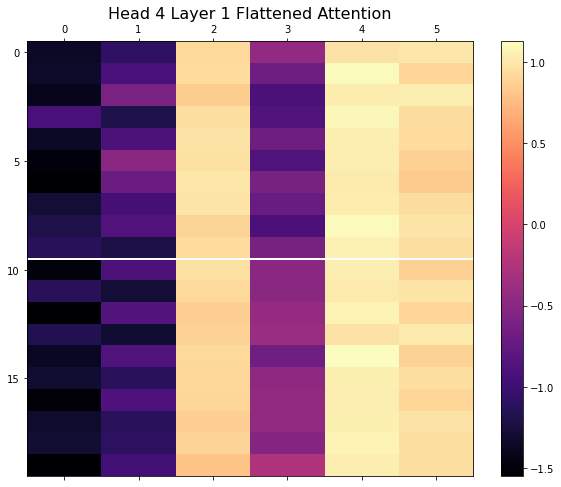

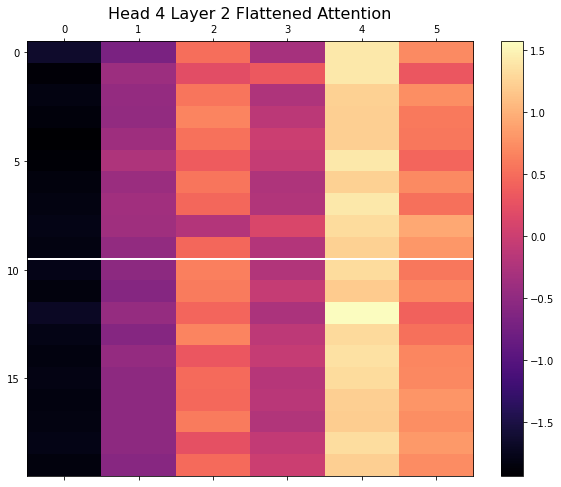

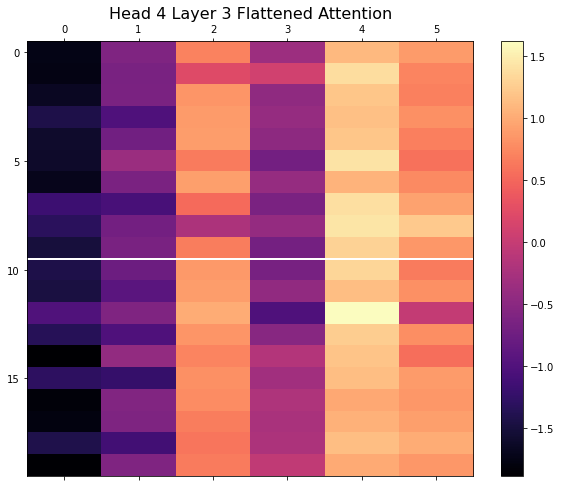

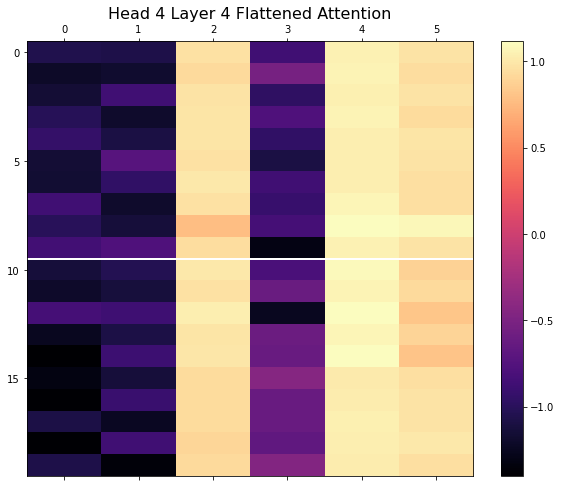

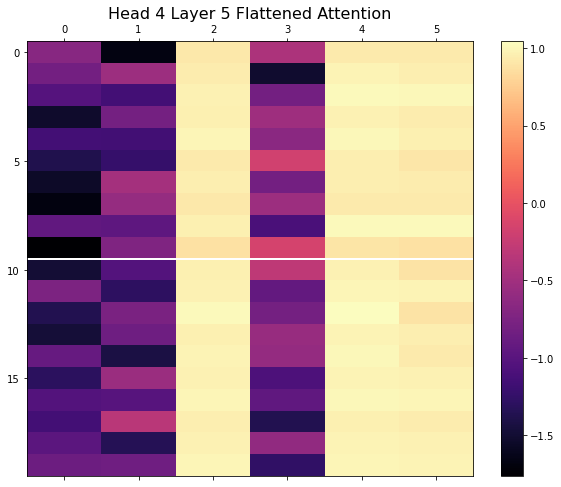

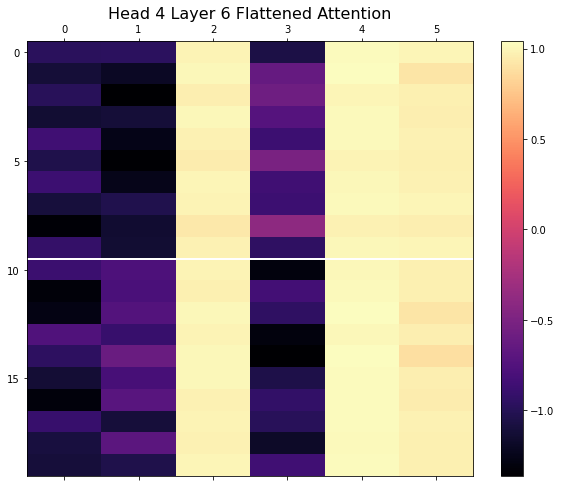

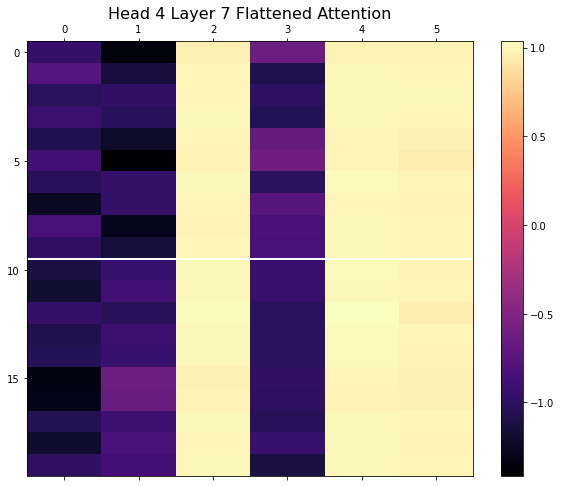

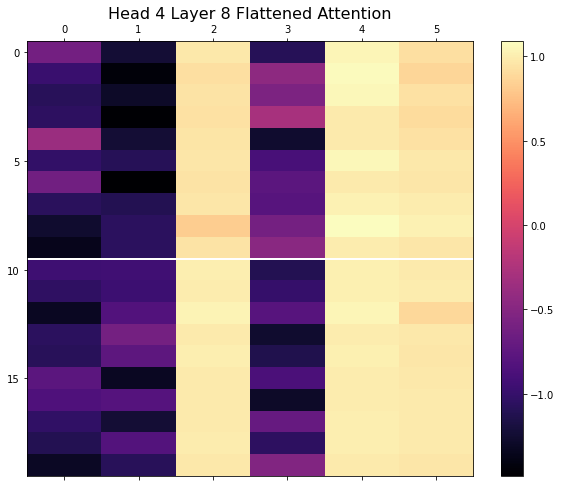

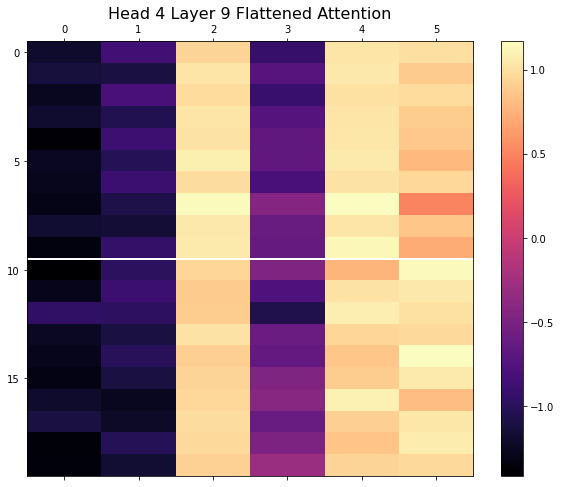

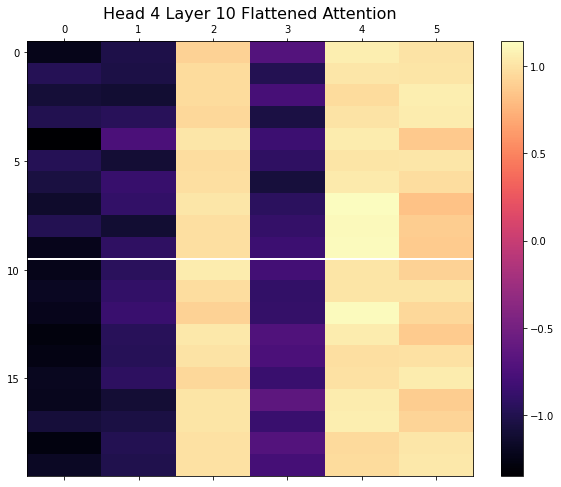

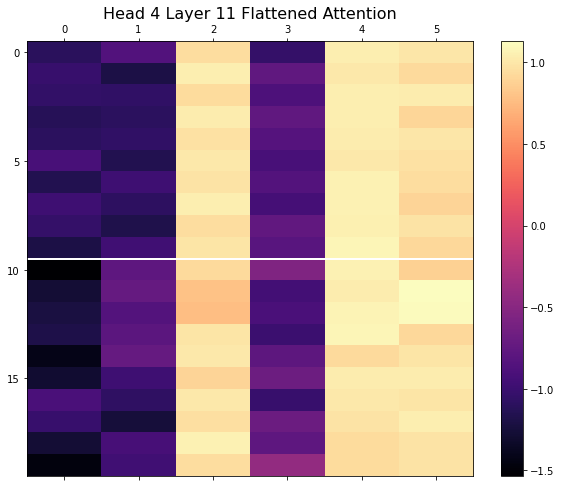

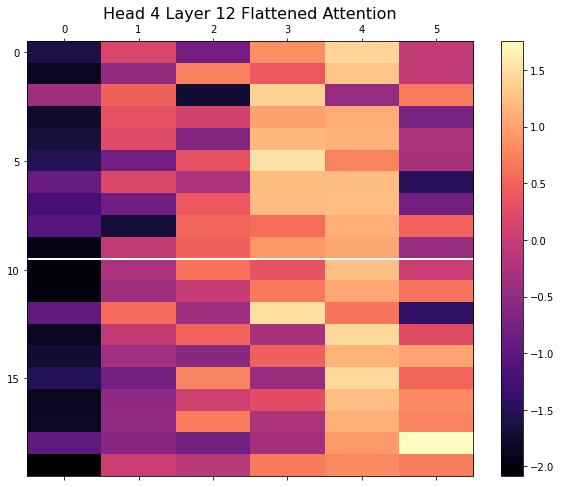

Layer 12 matrices saved to F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-attention.txt


In [ ]:
# get layer 7-12 matrices from cut_matrices
layers_matrices = {layer: [] for layer in range(1, 13)}
for i, matrix in enumerate(flattened_matrices):
    layer = i % 12 + 1 
    if 1 <= layer <= 12:
        layers_matrices[layer].append(matrix)

for layer, matrices in layers_matrices.items():
    flat_matrices = []
    for matrix in matrices:
        flat_matrix = matrix
        flat_matrices.append(flat_matrix)

    stacked_matrix = np.vstack(flat_matrices)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(stacked_matrix, cmap='magma', aspect='auto')
    ax.axhline(y = 9.5, color = 'w', linestyle = '-', linewidth = 2)
    ax.set_title(f'Head 4 Layer {layer} Flattened Attention', fontsize=16)
    fig.colorbar(cax)

    plt.show()

    if layer == 12:
        save_path = 'F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-attention.txt'
        np.savetxt(save_path, stacked_matrix[:20], fmt='%f') 
        print(f'Layer {layer} matrices saved to {save_path}')

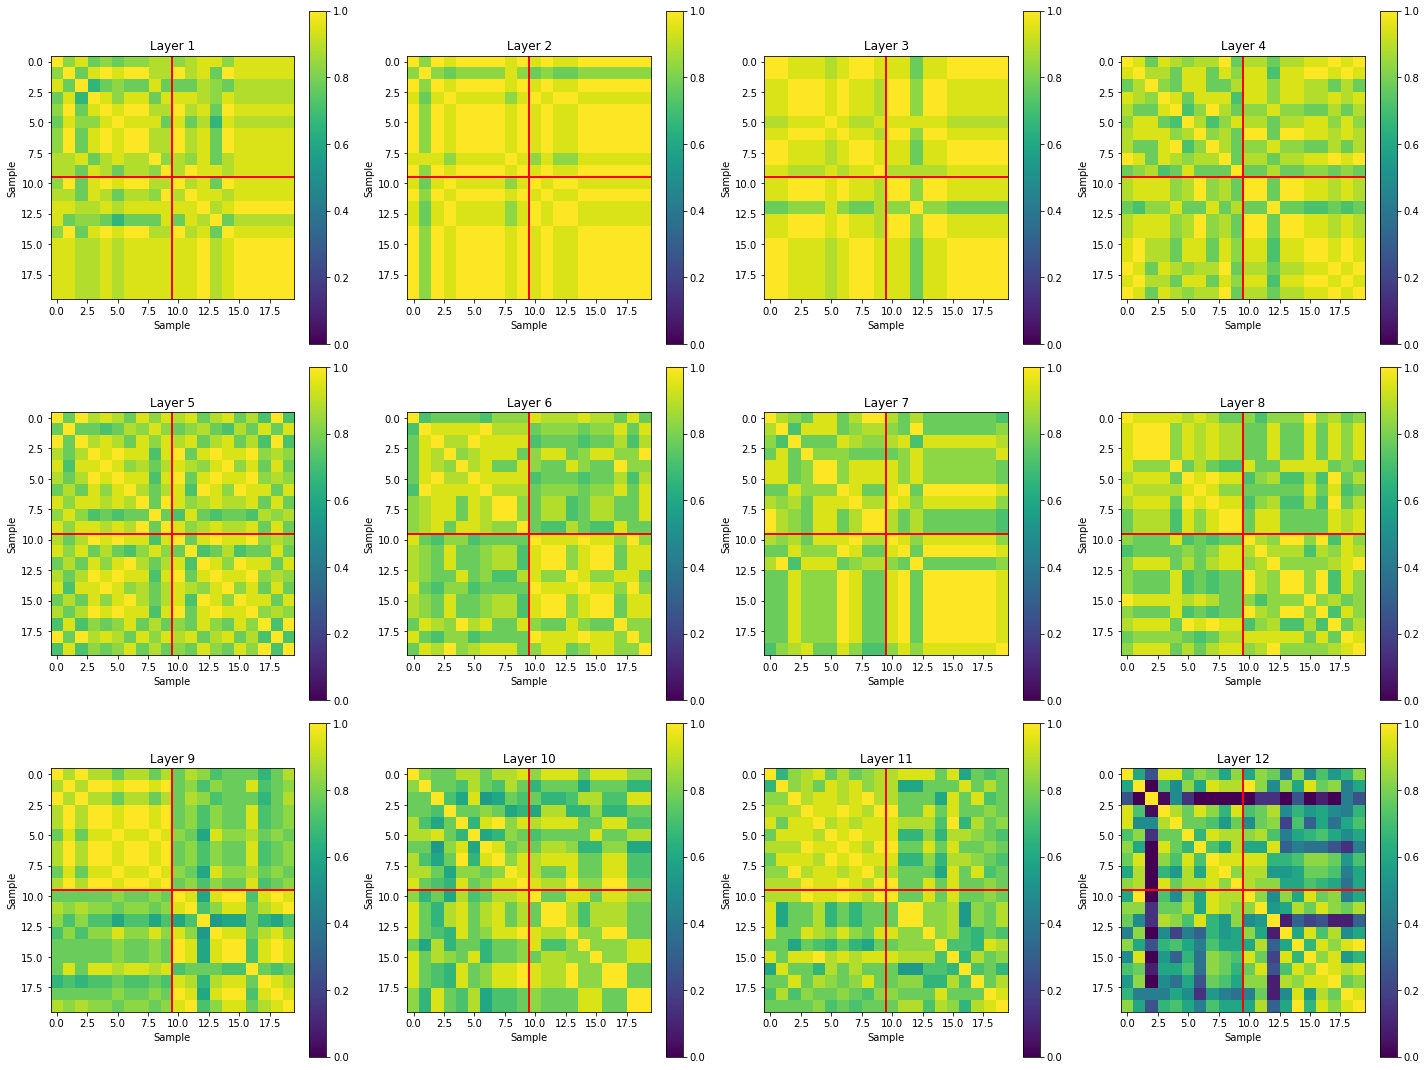

In [ ]:
from scipy.stats import spearmanr
# spearman corr
def calc_spearman_matrices(flattened_matrices, layers=12, samples=20):
    layer_matrices = []
    for layer in range(layers):
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                matrix_i = flattened_matrices[i*layers + layer]
                matrix_j = flattened_matrices[j*layers + layer]
                rho, _ = spearmanr(matrix_i, matrix_j)
                spearman_matrix[i, j] = rho
        layer_matrices.append(spearman_matrix)
    return layer_matrices

spearman_matrices = calc_spearman_matrices(flattened_matrices)

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(spearman_matrices[i], cmap = "viridis", vmin=0, vmax=1)
    ax.set_title(f'Layer {i+1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')
    plt.colorbar(im, ax=ax)
    ax.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
    ax.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()


2. Avg Embedding

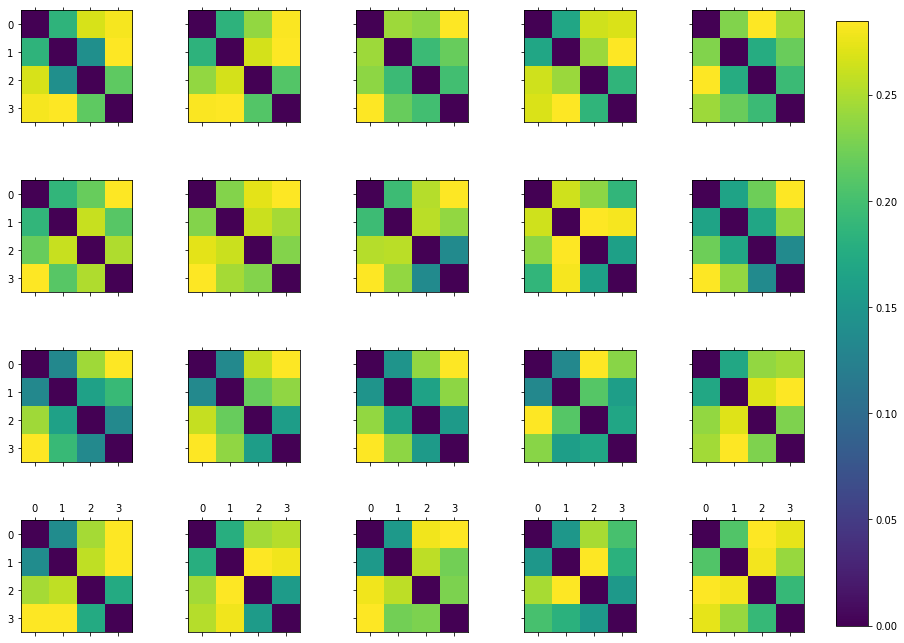

In [ ]:
    
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity


cn_stopwords_path = 'F:/project/Attention/cn_stopwords.txt'  
with open(cn_stopwords_path, 'r', encoding='utf-8') as f:
    cn_stopwords = {line.strip() for line in f.readlines()}

#cn_stopwords = []

tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall')
model = GPT2LMHeadModel.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall', output_hidden_states=True).eval()

# corpus
with open("F:/project/Attention/corpus.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

all_sim = []

for corpus_index, text in enumerate(corpus):  
    #sentences = text.split('。')[:-1]  
    #if not sentences: continue  

    #input_text = "[SEP] ".join(sentences) 

    #inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    sep_positions = [pos for pos, token in enumerate(tokens) if token == "。"]
    
    num_sentences = len(sep_positions) 
    
    all_embeddings = outputs.hidden_states[-1][0]
    
    sentence_sim = np.zeros((num_sentences, num_sentences))

    for i in range(num_sentences):
        start_from = 0 if i == 0 else sep_positions[i-1] + 1
        end_from = sep_positions[i]

        for j in range(num_sentences):
            start_to = 0 if j == 0 else sep_positions[j-1] + 1
            end_to = sep_positions[j]

            # stopwords
            valid_emb_values_i = []
            valid_emb_values_j = []
            for k in range(start_from, end_from):
                if tokens[k] not in cn_stopwords:
                    valid_emb_values_i.append(all_embeddings[k, :])
            for l in range(start_to, end_to):
                if tokens[l] not in cn_stopwords:
                    valid_emb_values_j.append(all_embeddings[l, :])


            if valid_emb_values_i and valid_emb_values_j:
                emb_i = torch.stack(valid_emb_values_i).mean(dim=0)
                emb_j = torch.stack(valid_emb_values_j).mean(dim=0)
                #sentence_sim[i,j] = euclidean_distances(emb_i.detach().numpy().reshape(1, -1), emb_j.detach().numpy().reshape(1, -1))
                sentence_sim[i,j] = 1-cosine_similarity(emb_i.detach().numpy().reshape(1, -1), emb_j.detach().numpy().reshape(1, -1))



    all_sim.append(sentence_sim)

    row = corpus_index // 5  
    col = corpus_index % 5  
    ax = axs[row, col]
    im = ax.matshow(sentence_sim, cmap='viridis')

    if col == 0:
        ax.set_yticks(range(1,len(sentences)+1))

cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7]) 
fig.colorbar(im, cax=cbar_ax)

        

[[       nan        nan        nan        nan]
 [0.26686877        nan        nan        nan]
 [0.3854652  0.20378029        nan        nan]
 [0.40376788 0.4096809  0.30767977        nan]]


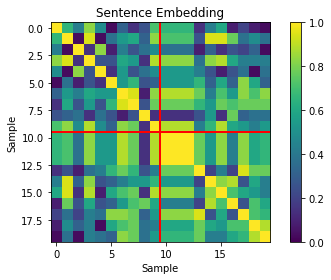

In [ ]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan)  
    transformed_matrix[tril_indices] = matrix[tril_indices] 
    return transformed_matrix

cut_matrices2 = []

for matrix in all_sim:
    cut_matrix = transform_matrix(matrix)
    cut_matrices2.append(cut_matrix)

print(cut_matrices2[0])

from scipy.stats import spearmanr
def calc_spearman_matrices(cut_matrices, layers=12, samples=20):
    layer_matrices = []
    for layer in range(layers):
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                matrix_i = cut_matrices[i*layers + layer]
                matrix_j = cut_matrices[j*layers + layer]
                flat_i = matrix_i.flatten()
                flat_j = matrix_j.flatten()
                valid_indices = ~np.isnan(flat_i) & ~np.isnan(flat_j)

                m1 = ((flat_i[valid_indices]) - np.mean(flat_i[valid_indices]))/np.std(flat_i[valid_indices])
                m2 = ((flat_j[valid_indices]) - np.mean(flat_j[valid_indices]))/np.std(flat_j[valid_indices])
                rho, _ = spearmanr(m1, m2)
                spearman_matrix[i, j] = abs(rho)  # only abs value
        layer_matrices.append(spearman_matrix)
    return layer_matrices

spearman_matrices = calc_spearman_matrices(cut_matrices2, 1, 20)


plt.imshow(spearman_matrices[0], cmap='viridis', vmin=0, vmax=1)
plt.title(f'Sentence Embedding')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()

In [ ]:
flattened_matrices2 = []

for matrix in cut_matrices2:
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix)
    final = (flattened_matrix[valid_indices] - np.mean(flattened_matrix[valid_indices]))/np.std(flattened_matrix[valid_indices])
    flattened_matrices2.append(final)

flattened_matrices2 = np.array(flattened_matrices2)
# flattened_matrices shape (15, n_features) 
# n_samples is 15 

print(flattened_matrices2[0])

[-0.81729058  0.72930457 -1.64001625  0.96798657  1.04509721 -0.28508151]


In [ ]:
save_path = 'F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-emb.txt'
np.savetxt(save_path, flattened_matrices2[:20], fmt='%f')  
print(f'emb matrices saved to {save_path}')

emb matrices saved to F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-emb.txt


3. Compare

0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.8857142857142858
0.0048046647230320545 0.7871720116618075 0.8717434402332361 0.01884548104956266


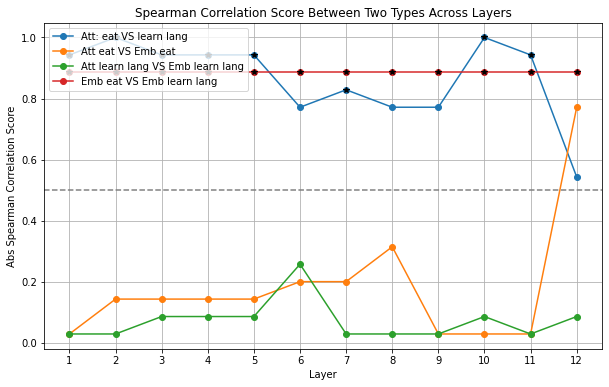

In [ ]:
avg_emb_type1 = np.mean(flattened_matrices2[:10], axis=0)
avg_emb_type2 = np.mean(flattened_matrices2[10:], axis=0)
#avg_emb_type1 = np.hstack(flattened_matrices2[:10])
#avg_emb_type2 = np.hstack(flattened_matrices2[10:])

from scipy.stats import spearmanr

# all_attentions is a list containing 180 4x4 matrices
# every 15 matrices is a layer, the first 10 one class，the rest 5 the other class

n_samples = 20
n_layers = 12
n_samples_per_layer = 20
spearman_scores1 = []
spearman_scores2 = []
spearman_scores3 = []
spearman_scores4 = []
pvalue1 = []
pvalue2 = []
pvalue3 = []
pvalue4 = []
layers = range(1, n_layers + 1)

for i in range(n_layers):
    current_layer_matrices = []
    for sample in range(n_samples):
        index = sample * n_layers + i
        current_layer_matrices.append(flattened_matrices[index])
    
    # avg matrix of two classes
    avg_matrix_type1 = np.mean(current_layer_matrices[:10], axis=0)
    avg_matrix_type2 = np.mean(current_layer_matrices[10:], axis=0)
    #avg_matrix_type1 = np.hstack(current_layer_matrices[:10])
    #avg_matrix_type2 = np.hstack(current_layer_matrices[10:])
    
    rho1, p1 = spearmanr(avg_matrix_type1, avg_matrix_type2)
    spearman_scores1.append(abs(rho1))
    pvalue1.append(p1)

    rho2, p2 = spearmanr(avg_matrix_type1, avg_emb_type1)
    spearman_scores2.append(abs(rho2))
    pvalue2.append(p2)

    rho3, p3 = spearmanr(avg_matrix_type2, avg_emb_type2)
    spearman_scores3.append(abs(rho3))
    pvalue3.append(p3)

    rho4, p4 = spearmanr(avg_emb_type1, avg_emb_type2)
    spearman_scores4.append(abs(rho4))
    pvalue4.append(p4)
    print(abs(rho4))

significance_threshold = 0.05

plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, linestyle="--", color='gray')
plt.plot(range(1, n_layers + 1), spearman_scores1, marker='o', linestyle='-', label='Att: eat VS learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores2, marker='o', linestyle='-', label='Att eat VS Emb eat')
plt.plot(range(1, n_layers + 1), spearman_scores3, marker='o', linestyle='-', label='Att learn lang VS Emb learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores4, marker='o', linestyle='-', label='Emb eat VS Emb learn lang')

for i, layer in enumerate(layers):
    if i == 3:
        print(pvalue1[i], pvalue2[i], pvalue3[i], pvalue4[i])
    if pvalue1[i] < significance_threshold:
        plt.plot(layer, spearman_scores1[i], marker='*', color='black')
    if pvalue2[i] < significance_threshold:
        plt.plot(layer, spearman_scores2[i], marker='*', color='black')
    if pvalue3[i] < significance_threshold:
        plt.plot(layer, spearman_scores3[i], marker='*', color='black')
    if pvalue4[i] < significance_threshold:
        plt.plot(layer, spearman_scores4[i], marker='*', color='black')

plt.xlabel('Layer')
plt.ylabel('Abs Spearman Correlation Score')
plt.title('Spearman Correlation Score Between Two Types Across Layers')
plt.legend(loc = "upper left")
plt.xticks(range(1, n_layers + 1)) 
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#cn_stopwords=[]
cn_stopwords_path = 'F:/project/Attention/cn_stopwords.txt' 
with open(cn_stopwords_path, 'r', encoding='utf-8') as f:
    cn_stopwords = {line.strip() for line in f.readlines()}

tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall')
model = GPT2LMHeadModel.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall', output_hidden_states=True)

# corpus
with open("F:/project/Attention/navi_chain.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]


all_sim = []

def cosine(u, v):
    sim = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    return sim

for corpus_index, text in enumerate(corpus):  
    #sentences = text.split('。')[:-1]  
    #if not sentences: continue  

    #input_text = "[SEP] ".join(sentences)

    #inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    sep_positions = [pos for pos, token in enumerate(tokens) if token == "。"]

    num_sentences = len(sep_positions)

    all_embeddings = outputs.hidden_states[-1][0]

    sentence_sim = np.zeros((num_sentences, num_sentences))

    for i in range(num_sentences):
        start_from = 0 if i == 0 else sep_positions[i-1] + 1
        end_from = sep_positions[i]

        for j in range(num_sentences):
            start_to = 0 if j == 0 else sep_positions[j-1] + 1
            end_to = sep_positions[j]

            # stopwords
            valid_emb_values_i = []
            valid_emb_values_j = []
            for k in range(start_from, end_from):
                if tokens[k] not in cn_stopwords:
                    valid_emb_values_i.append(all_embeddings[k, :])
            for l in range(start_to, end_to):
                if tokens[l] not in cn_stopwords:
                    valid_emb_values_j.append(all_embeddings[l, :])

            if valid_emb_values_i and valid_emb_values_j:
                emb_i = torch.stack(valid_emb_values_i).mean(dim=0)
                emb_j = torch.stack(valid_emb_values_j).mean(dim=0)
                sentence_sim[i, j] = cosine(emb_i.detach().numpy(), emb_j.detach().numpy().T)

    all_sim.append(sentence_sim)

    plt.figure()
    plt.matshow(sentence_sim, cmap='viridis')
    plt.colorbar()
    plt.title(f"Text {corpus_index}")
    plt.show()


In [ ]:

sim = all_sim[2]

#cosine similarity
adjacent_sim = [sim[i, i-1] for i in range(1, 14)]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 14), adjacent_sim, marker='o')
plt.xlabel('Sentence ID')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Between Adjacent Sentences: stopwords')
plt.xticks(range(1, 14))
plt.grid(True)
plt.show()